<a href="https://colab.research.google.com/github/allenye66/ML-Course/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://www.weenect.com/blog/wp-content/uploads/2018/07/accident-route-chien.jpg)

We work for CC: ConscientiousCars where we help self-driving vehicles be more conscientious of their surroundings. Our cars have been very good at recognizing and avoiding humans. They haven't, however, been capable of recognizing dogs. Since dogs are man's best friend and will always be where we humans are, we want our cars to know if a dog is on the road in front of them and avoid the dog. 

\\

The first step to avoiding these cute puppers is **knowing if a pupper is in front of the car**

\\

So, today, we will **build a detector that can tell when our car sees a dog or not**!


In [1]:
#@title Run this to load some packages and data! { display-mode: "form" }
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from collections import Counter
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def categorical_to_numpy(labels_in):
  labels = []
  for label in labels_in:
    if label == 'dog':
      labels.append(np.array([1, 0]))
    else:
      labels.append(np.array([0, 1]))
  return np.array(labels)


def load_data():
  # Run this cell to download our data into a file called 'cifar_data'
  import gdown
  gdown.download('https://drive.google.com/uc?id=1-BjeqccJdLiBA6PnNinmXSQ6w5BluLem','cifar_data','True'); # dogs v road;

  # now load the data from our cloud computer
  import pickle
  data_dict = pickle.load(open( "cifar_data", "rb" ));
  
  data   = data_dict['data']
  labels = data_dict['labels']
  
  return data, labels

def plot_one_image(data, labels, img_idx):
  from google.colab.patches import cv2_imshow
  import cv2
  import matplotlib.pyplot as plt
  my_img   = data[img_idx, :].squeeze().reshape([32,32,3]).copy()
  my_label = labels[img_idx]
  print('label: %s'%my_label)
  plt.imshow(my_img)
  plt.show()
  
def CNNClassifier(num_epochs=2, layers=1, dropout=0.15):
  def create_model():
    model = Sequential()
    model.add(Reshape((32, 32, 3)))
    
    for i in range(layers):
      model.add(Conv2D(32, (3, 3), padding='same'))
      model.add(Activation('relu'))
    
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    model.add(Dense(2))
    model.add(Activation('softmax'))

    # initiate RMSprop optimizer
    opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model
  return KerasClassifier(build_fn=create_model, epochs=num_epochs, batch_size=10, verbose=2)

def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')  
    ax.legend(loc = 1)    
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')
    
    plt.show()
    
def model_to_string(model):
    import re
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))
    sms = "\n".join(stringlist)
    sms = re.sub('_\d\d\d','', sms)
    sms = re.sub('_\d\d','', sms)
    sms = re.sub('_\d','', sms)  
    return sms

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Exploring CNN parameters.

Today, we will explore various hyperparameters of CNNs. We will use the same data from yesterday's dog/road dataset. To get started, let's load in our data and create our training and test set.


In [0]:
# load our data
data, labels = load_data()
inputs_train, inputs_test, labels_train, labels_test = model_selection.train_test_split(data, labels, test_size=0.2, random_state=1)

labels_train_numerical = categorical_to_numpy(labels_train)
labels_test_numerical = categorical_to_numpy(labels_test)

## TENSORFLOW PLAYGROUND CONTEST (OPTIONAL)

Open [this](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.62283&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&regularizationRate_hide=true&learningRate_hide=true&batchSize_hide=true&stepButton_hide=true&activation_hide=true) to understand Neural Networks!

**Today, let's see who can get the best accuracy on the spiral dataset. Play with as many parameters you want, including regularization, activation function, batch size, number of hidden layers, neurons per layer, etc.**

## Using a simple neural network

Let's now try a neural network for this and see how well it does. 

To build a simple neural network, we use `MLPClassifier` from scikit-learn. We will play with the **number of neurons** and the **number of hidden layers** to adjust the complexity of our model! Just like we did in Playground. 

Let's see how well we can do. :) 

**Example 1:**

If we want to create a neural network with 1 hidden layer and 3 neurons, we would say:

`nnet = MLPClassifier(hidden_layer_sizes=(3)) `

**Example 2:**

If we want to create a neural network with 2 hidden layers and 3 neurons in each layer:

`nnet = MLPClassifier(hidden_layer_sizes=(3, 3)) `

In [3]:
# Create and train our multi layer perceptron model
nnet = MLPClassifier(hidden_layer_sizes=(10), max_iter= 1000)  ## How many hidden layers? How many neurons does this have?

nnet.fit(inputs_train, labels_train)

# Predict what the classes are based on the testing data
predictions = nnet.predict(inputs_test)

# Print the score on the testing data
print("MLP Testing Set Score:")
print(accuracy_score(labels_test, predictions)*100)

MLP Testing Set Score:
52.916666666666664


**How well did your neural network perform?** 

Multilayer perceptrons aren't complex models and are more difficult to find the right "settings" for. It takes some trial and error!

**Try the following out and see how well you can get your network to do:**
* Change the number of hidden neurons and hidden layers to see how well you can do.
* Increase or decrease the number of iterations

### Excercise 1 ✍️

Using the MLP classifier, explore different numbers of hidden layers, the size of the hidden layers, and the number of iterations. You may use a for-loop if you would like!

In [6]:
### YOUR CODE HERE
### YOUR CODE HERE
for i in range(20):
  # Create and train our multi layer perceptron model
  nnet = MLPClassifier(hidden_layer_sizes=(20+(i+1)*2), max_iter= 10000)  ## How many hidden layers? How many neurons does this have?
  nnet.fit(inputs_train, labels_train)

  # Predict what the classes are based on the testing data
  predictions = nnet.predict(inputs_test)

  # Print the score on the testing data
  print("layer size:", (20+(i+1)*2),"= MLP Testing Set Score:")
  print(accuracy_score(labels_test, predictions)*100)
### END CODE
### END CODE

layer size: 22 = MLP Testing Set Score:
75.0
layer size: 24 = MLP Testing Set Score:
80.41666666666667
layer size: 26 = MLP Testing Set Score:
52.916666666666664
layer size: 28 = MLP Testing Set Score:
47.083333333333336
layer size: 30 = MLP Testing Set Score:
52.916666666666664
layer size: 32 = MLP Testing Set Score:
47.083333333333336
layer size: 34 = MLP Testing Set Score:
47.083333333333336
layer size: 36 = MLP Testing Set Score:
52.916666666666664
layer size: 38 = MLP Testing Set Score:
75.41666666666667
layer size: 40 = MLP Testing Set Score:
52.916666666666664
layer size: 42 = MLP Testing Set Score:
47.5
layer size: 44 = MLP Testing Set Score:
52.5
layer size: 46 = MLP Testing Set Score:
87.91666666666667
layer size: 48 = MLP Testing Set Score:
53.75
layer size: 50 = MLP Testing Set Score:
52.916666666666664
layer size: 52 = MLP Testing Set Score:
83.75
layer size: 54 = MLP Testing Set Score:
79.58333333333333
layer size: 56 = MLP Testing Set Score:
86.66666666666667
layer size:

## Models for vision: Convolutional Neural Networks

###Excercise 2 ✍️

There is a famous type of neural network known as convolutional neural networks (CNNs). These types of neural networks work particularly well on problems to do with computer vision. Let's try one out!

To load up a simple CNN on scikit-learn, just run:

`cnn = CNNClassifier(num_epochs=E, layers=L, dropout=D)`

The dropout represents how many weights we set to 0 during training time. This can help prevent overfitting.

**Try different values of num_epochs, layers, and dropout so that you get the highest accuracy model. Work with your instructors to review what each of these parameters mean and why they are affecting the model.**

In [76]:
### YOUR CODE HERE
'''
cnn = CNNClassifier(num_epochs = 20, layers = 3, dropout = 1)
cnn.fit(inputs_train, labels_train)
predictions = cnn.predict(inputs_test)
print(accuracy_score(labels_test, predictions)*100)
'''

for i in [10]:
  for j in [1,2,3]:
    for k in [0.2, 0.6, 0.8]:
      print("at", j, "layers +", "at", k, "dropout+", "at", i, "epochs:")
      cnn = CNNClassifier(num_epochs = i, layers = j, dropout = k)
      cnn.fit(inputs_train, labels_train)
      predictions = cnn.predict(inputs_test)
      print(accuracy_score(labels_test, predictions)*100) 

### END CODE

at 1 layers + at 0.2 dropout+ at 10 epochs:
Epoch 1/10
 - 1s - loss: 3.7654 - accuracy: 0.6958
Epoch 2/10
 - 0s - loss: 0.8830 - accuracy: 0.8313
Epoch 3/10
 - 0s - loss: 0.5039 - accuracy: 0.8844
Epoch 4/10
 - 0s - loss: 0.2668 - accuracy: 0.9198
Epoch 5/10
 - 0s - loss: 0.2481 - accuracy: 0.9229
Epoch 6/10
 - 0s - loss: 0.1835 - accuracy: 0.9292
Epoch 7/10
 - 0s - loss: 0.1796 - accuracy: 0.9448
Epoch 8/10
 - 0s - loss: 0.1637 - accuracy: 0.9500
Epoch 9/10
 - 0s - loss: 0.1265 - accuracy: 0.9448
Epoch 10/10
 - 0s - loss: 0.1098 - accuracy: 0.9646
95.41666666666667
at 1 layers + at 0.6 dropout+ at 10 epochs:
Epoch 1/10
 - 1s - loss: 12.8232 - accuracy: 0.5604
Epoch 2/10
 - 0s - loss: 3.5314 - accuracy: 0.6594
Epoch 3/10
 - 0s - loss: 1.6183 - accuracy: 0.7115
Epoch 4/10
 - 0s - loss: 0.7899 - accuracy: 0.8021
Epoch 5/10
 - 0s - loss: 0.6334 - accuracy: 0.8125
Epoch 6/10
 - 0s - loss: 0.4331 - accuracy: 0.8479
Epoch 7/10
 - 0s - loss: 0.3616 - accuracy: 0.8698
Epoch 8/10
 - 0s - loss: 

**How well did your neural network perform?** 

CNNs typically perform significantly better than MLPs on vision problems but, like MLPs, aren't always consistent when they are applied. They are also sensitive to a number of parameters. 

## Training and Validation Curves

An important aspect of training neural networks is to prevent overfitting. In brief, we know that our model is overfitting when validation (or test) accuracy is lower than the training accuracy.

In the first line of code below, we first **fit** the model on the training data and pass in some validation (or test) data to evaluate it. We call it the **history** because we want to retain information about the accuracy at each epoch.

In the second line we plot the history so that we can compare the training and validation accuracies.  

```
history = model.fit(inputs_train, labels_train, validation_data=(inputs_test, labels_test_numerical))
plot_acc(history)
```



###Excercise 3 ✍️

Plot a train vs. validation curve for our CNN model. 

**After how many epochs does the model begin to overfit? How does this vary as you vary the number of hidden layers and dropout?** Overfitting occurs when the validation accuracy starts to drop below the training accuracy.

Train on 960 samples, validate on 240 samples
Epoch 1/20
 - 1s - loss: 6.3866 - accuracy: 0.5708 - val_loss: 0.9175 - val_accuracy: 0.6208
Epoch 2/20
 - 1s - loss: 1.1201 - accuracy: 0.7177 - val_loss: 0.2278 - val_accuracy: 0.9250
Epoch 3/20
 - 1s - loss: 0.4815 - accuracy: 0.8188 - val_loss: 0.1966 - val_accuracy: 0.9375
Epoch 4/20
 - 1s - loss: 0.3953 - accuracy: 0.8573 - val_loss: 0.2278 - val_accuracy: 0.9500
Epoch 5/20
 - 1s - loss: 0.3134 - accuracy: 0.8729 - val_loss: 0.1841 - val_accuracy: 0.9292
Epoch 6/20
 - 1s - loss: 0.2969 - accuracy: 0.8844 - val_loss: 0.4260 - val_accuracy: 0.8208
Epoch 7/20
 - 1s - loss: 0.2494 - accuracy: 0.9021 - val_loss: 0.1655 - val_accuracy: 0.9417
Epoch 8/20
 - 1s - loss: 0.2740 - accuracy: 0.8896 - val_loss: 0.2080 - val_accuracy: 0.9250
Epoch 9/20
 - 1s - loss: 0.2205 - accuracy: 0.9250 - val_loss: 0.1691 - val_accuracy: 0.9583
Epoch 10/20
 - 1s - loss: 0.2209 - accuracy: 0.9146 - val_loss: 0.1837 - val_accuracy: 0.9333
Epoch 11/20
 - 1s - los

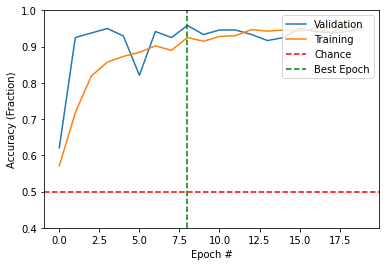

In [55]:
### YOUR CODE HERE
cnn = CNNClassifier(num_epochs = 20, layers = 3, dropout =0.5)

history = cnn.fit(inputs_train, labels_train, validation_data=(inputs_test, categorical_to_numpy(labels_test)))

plot_acc(history)

### END CODE

## Building Neural Networks from Scratch in Keras (Advanced)

We have been giving you helper functions which give you Keras neural networks pre-built for you. Now, we will build them on our own!



Let's walk though how to do this:

**1. Specify model**

```
model = Sequential()
```
In this line of code, we build our network where the information flows from LEFT to RIGHT through the network in ONE DIRECTION as opposed to multiple directions. Neurons on the right never pass informations to neurons on the left of it. 


**2. Add layers to the network**
```
model.add(Dense(4,input_shape = (3,), activation = 'sigmoid'))
```
In this code, we `add` a `layer` of neurons to our network. 

This layers consists of 4 neurons. Each neuron is DENSE and connects to all of the previous layer's inputs and all of the subsequent layers outputs. We specify that there are 3 inputs here.

We also specify what kind of output the neuron will give. If you want the neuron to output a number between 0 and 1 (like a probability!) you would use 'softmax' or 'sigmoid'. If you want the neuron to output any number, you can use 'linear'! You'll also often see 'relu', which is when a neuron will only output positive numbers. 

```
model.add(Dense(1, activation = 'linear'))
```
This code adds ANOTHER layer to the network that has 1 neuron. This one neuron is used to predict a continuous value!

**3. Turn the model on by compiling it** 

After having built the network, we want to train and use it, so we have to 'turn it on' and 'compile' it. To turn it on, we have to specify at the very least, a loss, an optimizer, and some ways of evaluating the model (metrics). Don't worry too much about what this means! Just know that this is necessary. 

```
model.compile(loss='mean_squared_error',
optimizer = 'adam',
metrics = ['mean_squared_error'])
  ```

Once we've created our network, we can use it very simply! Just like we did with sklearn, we define our input data (x), the true predictions from that data (y), and then train our model with `fit`. 

```
model.fit(x, y)
```


To use the model, you can use it to predict something with:
```
y = model.predict_classes(x)
```

You can actually use the model before you even train it! It just won't perform very well. 

###Excercise 4 ✍️




We're going to build this model: 

![](http://cs231n.github.io/assets/nn1/neural_net.jpeg)

This network can be described as: 
* Input Layer: 3
* Layer 1 (Hidden): 4 neurons that are activated by `'relu'`
* Layer 2 (Output): 2 neurons that are activated by `'softmax'`


We also want to compile the model with
`loss = 'categorical_crossentropy'`

In [0]:
# Fill in the blanks with your group!
### YOUR CODE HERE:
model_1 = Sequential()
model_1.add(Dense(4, input_shape = (3,), activation = 'relu'))
model_1.add(Dense(2, activation = 'softmax'))
model_1.compile(loss='categorical_crossentropy',
                optimizer = 'adam', 
                metrics = ['accuracy'])
### END CODE

###Excercise 5 ✍️

![](http://cs231n.github.io/assets/nn1/neural_net2.jpeg)

* Input Layer: 3 Neurons

* Layer 1: 4 neurons that are activated by '`relu' `and take in 3 inputs.

* Layer 2: 4 neurons that are activated by `'relu'`

* Layer 3 (out): 1 neurons that is activated by `'sigmoid'`

Compile the model with
`loss = 'binary_crossentropy'`

In [0]:
### YOUR CODE HERE
model_2 = Sequential()
model_2.add(Dense(4, input_shape = (3,), activation = 'relu'))
model_2.add(Dense(4, activation = 'relu'))
model_2.add(Dense(1, activation = 'sigmoid'))
model_2.compile(loss='categorical_crossentropy',
                optimizer = 'adam', 
                metrics = ['accuracy'])
### END CODE


###Excercise 6 ✍️

Now that we know how to build simple neural networks in Keras, let's build a CNN that will perform well on our data set of car and road images. 

Below is Keras code for a CNN. It will run as-is on the conscientious cars dataset. However, the performance is suboptimal. Add more layers and change the neural network hyperparameters so that the performance will be better. **Can you get the train and validation accuracy to both be higher than 90%?**

The Keras core layer API may be a useful reference: https://keras.io/layers/core/ 

In particular and in addition to adding more of the existing convolutional layers and activations, consider using the following layers:

`Dropout(N)`

`MaxPooling2D(pool_size=(N, N))`

Dropout and max-pooling operations should be applied at appropriate parts of the network.

Train on 960 samples, validate on 240 samples
Epoch 1/70
960/960 [==============================] - 0s 336us/step - loss: 46.8057 - accuracy: 0.5688 - val_loss: 15.6387 - val_accuracy: 0.4958
Epoch 2/70
960/960 [==============================] - 0s 156us/step - loss: 21.3349 - accuracy: 0.6521 - val_loss: 1.8436 - val_accuracy: 0.7292
Epoch 3/70
960/960 [==============================] - 0s 160us/step - loss: 14.6190 - accuracy: 0.6833 - val_loss: 0.5882 - val_accuracy: 0.8667
Epoch 4/70
960/960 [==============================] - 0s 166us/step - loss: 10.1993 - accuracy: 0.7073 - val_loss: 0.4295 - val_accuracy: 0.9000
Epoch 5/70
960/960 [==============================] - 0s 152us/step - loss: 7.6446 - accuracy: 0.6938 - val_loss: 1.0256 - val_accuracy: 0.7292
Epoch 6/70
960/960 [==============================] - 0s 162us/step - loss: 4.1444 - accuracy: 0.7479 - val_loss: 0.6923 - val_accuracy: 0.8000
Epoch 7/70
960/960 [==============================] - 0s 156us/step - loss: 3.2476 - 

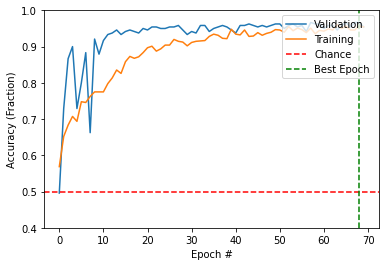

In [75]:
##### YOUR CODE HERE

model = Sequential()
model.add(Reshape((32, 32, 3)))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))



model.add(Dense(28, activation = 'relu'))
model.add(Dropout(0.9))



model.add(Flatten())
model.add(Dense(512))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Train the CNN and plot accuracy.
history = model.fit(inputs_train, labels_train_numerical, \
                    validation_data=(inputs_test, labels_test_numerical), \
                    epochs=70)
plot_acc(history)

##### END CODE

![](https://images.pexels.com/photos/316/black-and-white-animal-dog-pet.jpg?auto=compress&cs=tinysrgb&dpr=2&h=650&w=940)